# MS2LDA for GNPS

---

In [1]:
import os
os.chdir("../")
print(os.getcwd())

/Users/rosinatorres/Documents/PhD/WP1/Project/Code/MS2LDA/MS2LDA


### Load modules
MS2LDA is a very flexible program and consists of many modules. In the next step we load all the modules to build our workflow. Additionally, we load rdkit, pandas and numpy for some notebook scripting.

In [2]:
from MS2LDA.Preprocessing.load_and_clean import load_mgf
from MS2LDA.Preprocessing.load_and_clean import clean_spectra

from MS2LDA.Preprocessing.generate_corpus import features_to_words
from MS2LDA.Preprocessing.generate_corpus import combine_features

from MS2LDA.modeling import define_model
from MS2LDA.modeling import train_model
from MS2LDA.modeling import extract_motifs
from MS2LDA.modeling import create_motif_spectra

from MS2LDA.Add_On.Spec2Vec.annotation import load_s2v_and_library
from MS2LDA.Add_On.Spec2Vec.annotation import calc_embeddings, calc_similarity
from MS2LDA.Add_On.Spec2Vec.annotation import get_library_matches

from MS2LDA.Add_On.Spec2Vec.annotation_refined import mask_spectra
from MS2LDA.Add_On.Spec2Vec.annotation_refined import refine_annotation

from MS2LDA.Add_On.Fingerprints.FP_annotation import annotate_motifs as calc_fingerprints

from MS2LDA.Add_On.MassQL.MassQL4MotifDB import motifs2motifDB
from MS2LDA.Add_On.MassQL.MassQL4MotifDB import motifDB2motifs

from MS2LDA.Add_On.NTS.Screening import run_screen
from MS2LDA.Add_On.NTS.Screening import save_as_csv

from MS2LDA.motif_parser import store_m2m_folder
from MS2LDA.motif_parser import load_m2m_folder

from massql import msql_engine

import pandas as pd
import numpy as np

from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import RDKFingerprint

from MS2LDA.Visualisation.visualisation import create_network
from MS2LDA.Visualisation.visualisation import create_interactive_motif_network

### Workflow
The common *MS2LDA* workflow consists of 4 steps. 
- Modeling
- Annotation
- Screening
- Storing/Database
  
The next three functions are for the first 3 steps: Modeling, Annotation, and Screening.

#### Modeling
The first step is to apply *MS2LDA* to an unseen dataset to discover substructure patterns (motifs). The function combines the loading, cleaning, corpus generation and modeling and returns matchms spectrum objects for each pattern. The settings for LDA can be set according to the tomotopy documentation.

In [3]:
def generate_motifs(mgf_path, 
                    n_motifs = 50,
                    model_parameters = {
                        "rm_top": 0,
                        "min_cf": 0,
                        "min_df": 0,
                        "alpha": 0.1,
                        "eta": 0.1,
                        "seed": 42,
                    },
                    train_parameters = {
                        "parallel": 3
                    }, 
                    motif_parameter = 20,
                    charge=1,
                    motifset_name="unknown"):
    
    """generates the motif spectra based on a given mgf file
    
    ARGS:
        mgf_path (str): path to the mgf file
        model_parameters (dict): model parameters that can be set for a tomotopy LDA model
        train_parameters (dict): train parameters that can be set for a tomotopy training of an LDA model
        motif_parameter (int): number of top n most important features per motif
        
    RETURNS:
        motif_spectra (list): list of matchms spectrum objects (no precursor ion) 
    """
    # Preprocessing
    loaded_spectra = load_mgf(mgf_path)
    cleaned_spectra = clean_spectra(loaded_spectra)

    # Corpus Generation
    fragment_words, loss_words = features_to_words(cleaned_spectra)
    feature_words = combine_features(fragment_words, loss_words)

    # Modeling
    ms2lda = define_model(n_motifs=n_motifs, model_parameters=model_parameters)
    trained_ms2lda = train_model(ms2lda, feature_words, iterations=1000, train_parameters=train_parameters)

    # Motif Generation
    motifs = extract_motifs(trained_ms2lda, top_n=motif_parameter)
    motif_spectra = create_motif_spectra(motifs, charge, motifset_name)

    return cleaned_spectra,motif_spectra

#### Annotation
After the generation of motifs, we want to know what the patterns could stand for. Therefore we use a retrained Spec2Vec model to find the best database matches. The assumption is that compounds with the found motif will have a higher similarity then the ones that don't. In an optimization step, it is checked that the retrieved database matches are similar in their spectra to a certain extend and that the motif contains only the fragments and losses that really represent the substructure found.

In [4]:
def annotate_motifs(motif_spectra,top_n_matches = 5,
                    unique_mols = True,
                    path_model = "MS2LDA/Add_On/Spec2Vec/model_positive_mode/020724_Spec2Vec_pos_CleanedLibraries.model",
                    path_library = "MS2LDA/Add_On/Spec2Vec/model_positive_mode/positive_s2v_library.pkl"):
    """annotates motif with Spec2Vec
    
    ARGS:
        top_n_matches (int): top n compounds retrieved the database 
        unique_mols (boolean): True if only unique compounds or False duplicates can also be retrieved
        path_model (str): path to Spec2Vec model
        path_library (str): path the pkl library file, which contains embeddings, spectra and smiles
        
    RETURNS:
        optimized_motif_spectra (list): list of matchms motif spectra
        optimized_clusters (list): list of lists of spectra from clustered compounds
        smiles_clusters (list) list of lists of SMILES for clustered compounds
    """

    
    s2v_similarity, library = load_s2v_and_library(path_model, path_library)
    print("Model loaded ...")

    motif_embeddings = calc_embeddings(s2v_similarity, motif_spectra)
    similarity_matrix = calc_similarity(motif_embeddings, library.embeddings)
   
    matching_settings = {
                        "similarity_matrix": similarity_matrix,
                        "library": library,
                        "top_n": 5,
                        "unique_mols": True,
                    }

    
    library_matches = get_library_matches(matching_settings)

    masked_motif_spectra = mask_spectra(motif_spectra)
    optimized_motif_spectra, optimized_clusters, smiles_clusters, clusters_similarity = refine_annotation(s2v_similarity, library_matches, masked_motif_spectra, motif_spectra)

    return optimized_motif_spectra, optimized_clusters, smiles_clusters, clusters_similarity
    

#### Screening
When a motif is identified, we would like to use it to do a suspect screening for this substructure in a new dataset. Therefore screening can be used, which categorizes matches based on 3 criteria into 4 different groups.

In [5]:
def screen_motifs(mgf_path, optimized_motif_spectra, smiles_clusters, motif_selection=[0], save=False):
    """looks for motifs in unknown spectra"""
    loaded_spectra_to_screen = load_mgf(mgf_path)
    cleaned_spectra_to_screen = clean_spectra(loaded_spectra_to_screen)
    
    for idx, motif_smiles in zip(motif_selection, smiles_clusters):
        A,B,C,D = run_screen(optimized_motif_spectra[idx], cleaned_spectra_to_screen)
        if save == True:
            motif_smiles = motif_smiles[0]
            results = save_as_csv(A, motif_smiles)
    return A,B,C,D

In [6]:
mgf_path_train = "datasets/GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf"

In [7]:
%%time
cleaned_spectra,motif_spectra = generate_motifs(mgf_path_train, n_motifs=50)

CPU times: user 2min 2s, sys: 3.38 s, total: 2min 6s
Wall time: 34.3 s


In [8]:
#create_network(motif_spectra)

In [9]:
#motif_spectra_filtered = []
#for spectrum in motif_spectra:
 #   if len(spectrum.peaks.mz) > 2 and len(spectrum.losses.mz) > 2:
  #      motif_spectra_filtered.append(spectrum)

#len(motif_spectra_filtered)

In [10]:
%%time
optimized_motif_spectra, optimized_clusters, smiles_clusters, clusters_similarity = annotate_motifs(motif_spectra)

In [ ]:
#%matplotlib qt

In [ ]:
#colors = []
#for fp in fps:
#fp_vec = ExplicitBitVect(len(fp))
 #   for i, bit in enumerate(fp):
  #      if bit:
   #         fp_vec.SetBit(i)
    #similarity = DataStructs.TanimotoSimilarity(fp_vec, mc_fp)
    #print(similarity)
    #if similarity > 0.7:
     #   colors.append('red')
    #else:
     #   colors.append('blue')

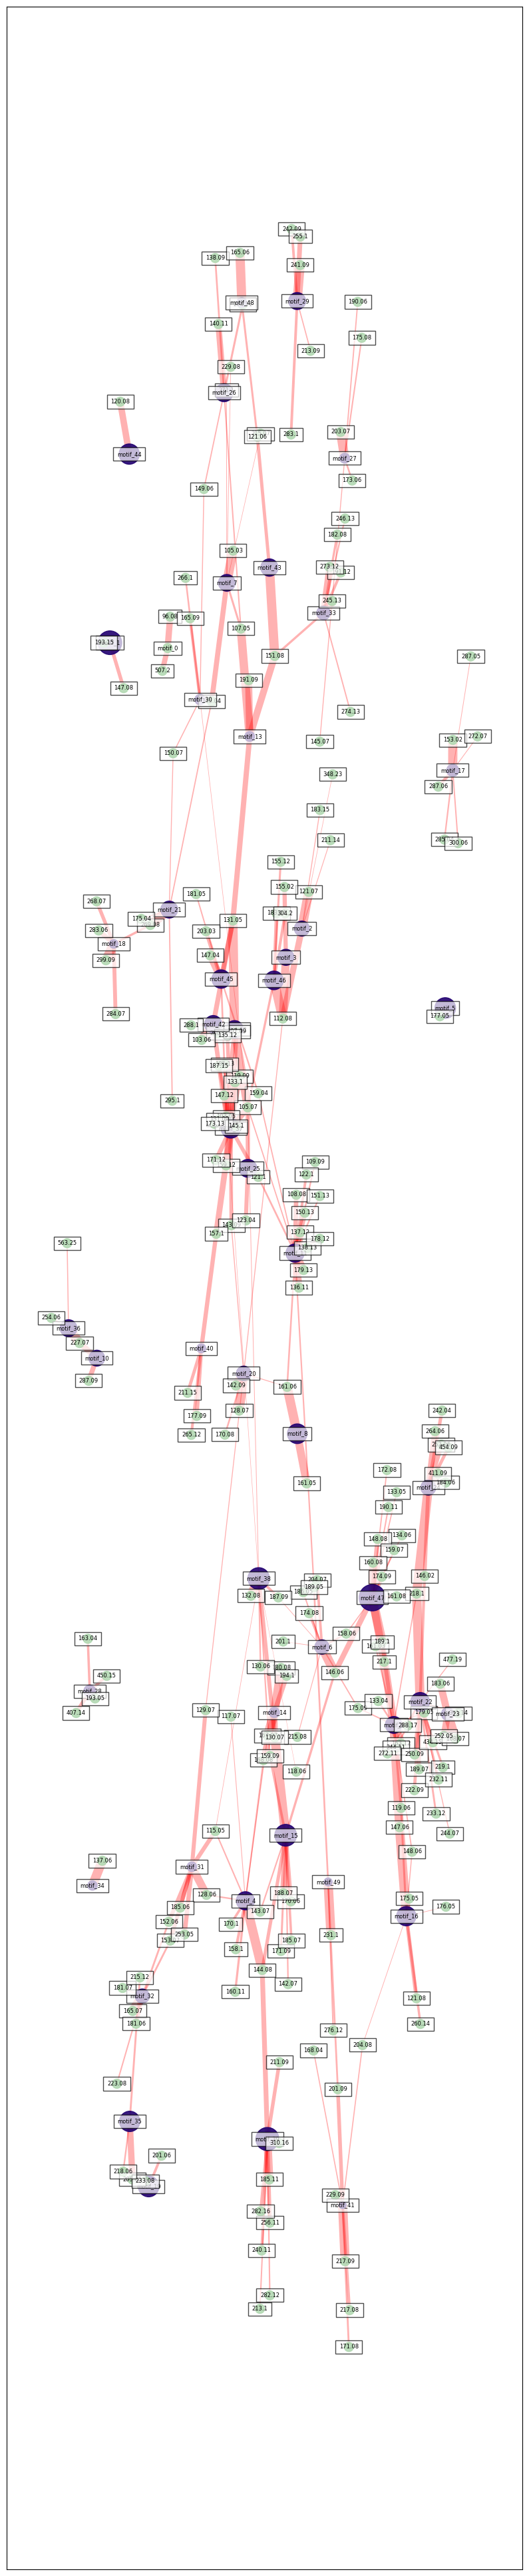

In [ ]:
#create_interactive_motif_network(optimized_motif_spectra, 2, clusters_similarity, smiles_clusters, optimized_clusters, motif_colors=None)


In [ ]:
mols = []
legends = []
for spec, similarity in zip(optimized_motif_spectra, clusters_similarity):
    if type(similarity) == np.float64:
        similarity = round(similarity, 2)
    n_frags = len(spec.peaks.mz)
    n_losses = len(spec.losses.mz)
    n_features = n_frags + n_losses
    motif_id = spec.get("id")
    smiles_list = spec.get("short_annotation")
    for smiles in smiles_list:
        mols.append(MolFromSmiles(smiles))
        legends.append(f"{motif_id} \n {n_features} features \n similarity: {similarity}")



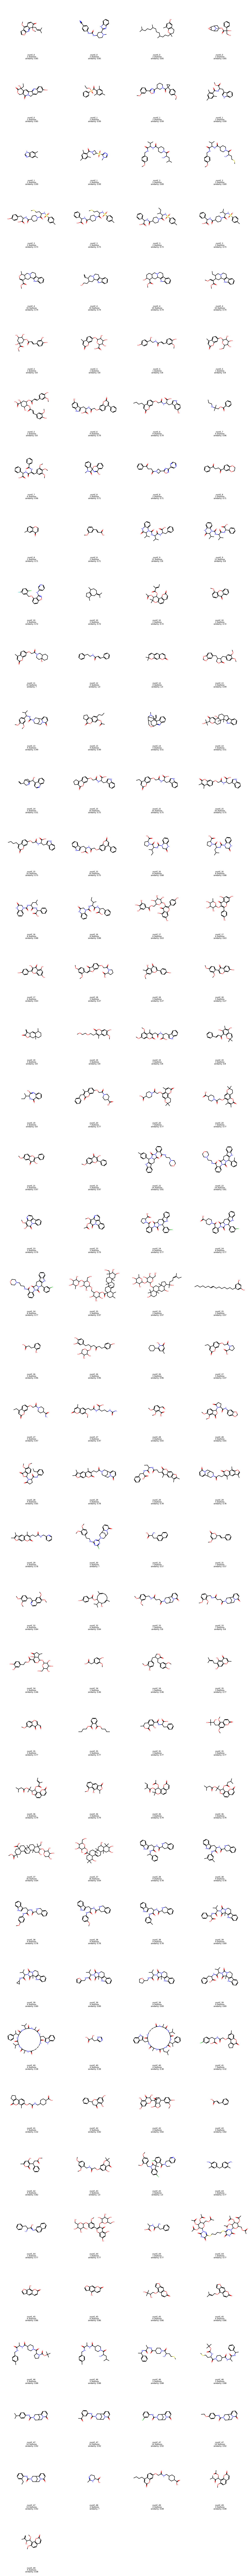

In [ ]:
MolsToGridImage(mols, molsPerRow=4, legends=legends, maxMols=222, subImgSize=(300, 300))

In [ ]:
i = 9

In [ ]:
smiles_gnps=[]

for i in cleaned_spectra:
    smiles_gnps.append(i.get("smiles"))

In [ ]:
list_of_gnps_smiles = [[smiles] for smiles in smiles_gnps]

# Output the result
print(list_of_gnps_smiles)

[['OC(=O)[C@H](NC(=O)CCN1C(=O)[C@@H]2Cc3ccccc3CN2C1=O)c4ccccc4'], ['O=C(N1[C@@H](C#N)C2OC2c3ccccc13)c4ccccc4'], ['COc1cc(O)c2c(=O)cc(oc2c1)c3ccccc3'], ['COc1c2OCOc2cc(CCN(C)C(=O)c3ccccc3)c1/C=C\\4/C(=O)NC(=O)N(CC=C)C4=O'], ['CC(C)[C@H](NC(=O)N1[C@@H](C(C)C)C(=O)Nc2ccccc12)C(=O)N[C@@H](Cc3ccccc3)C(=O)O'], ['OC(COC(=O)c1ccccc1)C(O)C(O)COC(=O)c2ccccc2'], ['Cc1c(Cc2ccccc2)c(=O)oc3c(C)c(OCC(=O)N[C@@H](Cc4ccccc4)C(=O)O)ccc13'], ['CC(Cc1c[nH]c2ccccc12)C(=O)O'], ['COc1ccc(CNC(=O)[C@@H](NC(=O)C2CCN(CC2)C(=O)[C@@H](N)CC(C)C)C(C)C)cc1'], ['Cc1c(Br)c(=O)oc2cc(OCC(=O)N3C[C@H]4C[C@@H](C3)c5cccc(=O)n5C4)ccc12'], ['COC1=C[C@]2(CC=C)[C@H](C)[C@@H](OC2=CC1=O)c3ccc4OCOc4c3'], ['CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CC(=O)O)C(=O)O'], ['C/C=C(\\C)/C(=O)N[C@H]([C@@H](O)C(=O)O[C@H]\\1C[C@@]2(O)[C@@H](OC(=O)c3ccccc3)C4[C@@]5(CO[C@@H]5C[C@H](O)[C@@]4(C)C(=O)[C@H](OC(=O)C)/C(=C1\\C)/C2(C)C)OC(=O)C)c6ccccc6'], ['COc1cc2[nH]c3ccccc3c2cc1C'], ['O=C(Oc1cccc2ccccc12)c3ccccc3'], ['COc1ccc2[nH]c

In [ ]:
motif_fps = calc_fingerprints(smiles_clusters, fp_type="maccs", threshold=0.6)
gnps_fps = calc_fingerprints(list_of_gnps_smiles, fp_type="maccs", threshold=0.6)


[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[

In [ ]:
comp_names=[]
for i in cleaned_spectra:
    comp_names.append(i.get("compound_name"))

print(comp_names)

file_path = "GNPSlibrary_comp_name.txt"

with open(file_path, 'w') as file:
    for name in comp_names:
        file.write(name + "\n")

['(2R)-2-[3-[(10aS)-1,3-dioxo-10,10a-dihydro-5H-imidazo[1,5-b]isoquinolin-2-yl]propanoylamino]-2-phenylacetic acid"', '(2S)-3-benzoyl-2,7b-dihydro-1aH-oxireno[2,3-c]quinoline-2-carbonitrile"', '5-hydroxy-7-methoxy-2-phenylchromen-4-one', 'N-[2-[7-methoxy-6-[(Z)-(2,4,6-trioxo-1-prop-2-enyl-1,3-diazinan-5-ylidene)methyl]-1,3-benzodioxol-5-yl]ethyl]-N-methylbenzamide"', '(2S)-2-[[(2S)-3-methyl-2-[[(2S)-3-oxo-2-propan-2-yl-2,4-dihydroquinoxaline-1-carbonyl]amino]butanoyl]amino]-3-phenylpropanoic acid"', '', '(2S)-2-[[2-(3-benzyl-4,8-dimethyl-2-oxochromen-7-yl)oxyacetyl]amino]-3-phenylpropanoic acid"', '3-(1H-indol-3-yl)-2-methylpropanoic acid', '1-[(2S)-2-amino-4-methylpentanoyl]-N-[(2S)-1-[(4-methoxyphenyl)methylamino]-3-methyl-1-oxobutan-2-yl]piperidine-4-carboxamide', '', '(2R,3S,3aS)-2-(1,3-benzodioxol-5-yl)-5-methoxy-3-methyl-3a-prop-2-enyl-2,3-dihydro-1-benzofuran-6-one"', '(2S)-2-[[1-[(2S)-3-methyl-2-[(4-methylphenyl)sulfonylamino]butanoyl]piperidine-4-carbonyl]amino]butanedioic aci

In [ ]:
prec_mass=[]
for i in cleaned_spectra:
    prec_mass.append(i.get("precursor_mz"))



In [ ]:
smiles_gnps=[]
for i in cleaned_spectra:
    smiles_gnps.append(i.get("smiles"))

In [ ]:
## KNOWN NAMES

In [ ]:
# Create a list of tuples that includes the original index, filtering out unwanted comp_names
comp_weight_with_index = [
    (index, (name, mass, smiles))
    for index, (name, mass, smiles) in enumerate(zip(comp_names, prec_mass, smiles_gnps))
    if name and name.strip()  # Keep only non-empty names
]

# Sort the list by the second element (prec_mass) in descending order
comp_weight_sorted_list = sorted(comp_weight_with_index, key=lambda x: x[1][1], reverse=True)

print(comp_weight_sorted_list)

[(533, ('[5-hydroxy-6-[2-(3-hydroxy-4-methoxyphenyl)ethoxy]-2-(hydroxymethyl)-4-[(2R,3R,4R,5R,6S)-3,4,5-trihydroxy-6-methyloxan-2-yl]oxyoxan-3-yl] (E)-3-(4-hydroxy-3-methoxyphenyl)prop-2-enoate"', 675.226, 'COc1ccc(CCOC2OC(CO)C(OC(=O)/C=C/c3ccc(O)c(OC)c3)C(O[C@H]4O[C@@H](C)[C@H](O)[C@@H](O)[C@H]4O)C2O)cc1O')), (532, ('[5-hydroxy-6-[2-(3-hydroxy-4-methoxyphenyl)ethoxy]-2-(hydroxymethyl)-4-[(2R,3R,4R,5R,6S)-3,4,5-trihydroxy-6-methyloxan-2-yl]oxyoxan-3-yl] (E)-3-(4-hydroxy-3-methoxyphenyl)prop-2-enoate"', 653.245, 'COc1ccc(CCOC2OC(CO)C(OC(=O)/C=C/c3ccc(O)c(OC)c3)C(O[C@H]4O[C@@H](C)[C@H](O)[C@@H](O)[C@H]4O)C2O)cc1O')), (1097, ('(4S,7S,10S,13S)-7-benzyl-13-[(4-hydroxyphenyl)methyl]-4,6,12-trimethyl-10-(2-methylpropyl)-3,6,9,12,15-pentazabicyclo[14.4.0]icosa-1(20),16,18-triene-2,5,8,11,14-pentone"', 642.329, 'CC(C)C[C@@H]1NC(=O)[C@H](Cc2ccccc2)N(C)C(=O)[C@H](C)NC(=O)c3ccccc3NC(=O)[C@H](Cc4ccc(O)cc4)N(C)C1=O')), (1265, ('methyl 3-ethenyl-4-[[6-[4-(4-hydroxyphenyl)-2-oxobutyl]-4-oxooxan-2-yl]m

In [ ]:
## UN KNOWN

In [ ]:
comp_weight_with_index = list(enumerate(zip(comp_names, prec_mass, smiles_gnps)))

# Sort the list by the second element (prec_mass) in descending order
comp_weight_sorted_list = sorted(comp_weight_with_index, key=lambda x: x[1][1], reverse=True)

# Save the sorted list to a text file
with open('comp_weight_sorted.txt', 'w') as f:
    for index, (name, mass, smiles) in comp_weight_sorted_list:
        f.write(f'{index}\t{name}\t{mass}\t{smiles}\n')

In [ ]:
subs = []
for i, (motif_fps, less_gnps_fps) in enumerate(zip(motif_fps, less_gnps_fps)):
    sub = substructure_check(motif_fps, less)
    subs.append(sub)
    print(i, sub)

print("Median:", np.median(subs))
print("Average:", np.average(subs))

0 0.7843137254901961
1 0.6153846153846154
2 0.3392857142857143
3 0.6029411764705882
4 0.6595744680851063
5 0.7575757575757576
6 0.8627450980392157
7 0.7058823529411765
8 0.7619047619047619
9 0.75
10 0.9
11 0.7586206896551724
12 1.0
13 0.5833333333333334
14 0.20833333333333334
15 0.8269230769230769
16 0.7307692307692307
17 0.875
18 0.6896551724137931
19 0.6764705882352942
20 0.49206349206349204
21 0.9310344827586207
22 0.7014925373134329
23 0.7857142857142857
24 0.696969696969697
25 0.84
26 0.7666666666666667
27 0.4827586206896552
28 0.2807017543859649
29 0.5
30 0.6774193548387096
31 0.8888888888888888
32 1.0
33 0.7368421052631579
34 0.3333333333333333
35 0.7941176470588235
36 0.8055555555555556
37 0.68
38 0.8837209302325582
39 0.7419354838709677
40 0.7058823529411765
41 0.8979591836734694
42 0.8695652173913043
43 0.6428571428571429
44 0.7419354838709677
45 0.8846153846153846
46 0.8478260869565217
47 0.7777777777777778
48 0.6388888888888888
49 0.84375
Median: 0.7459677419354839
Average:

(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>)

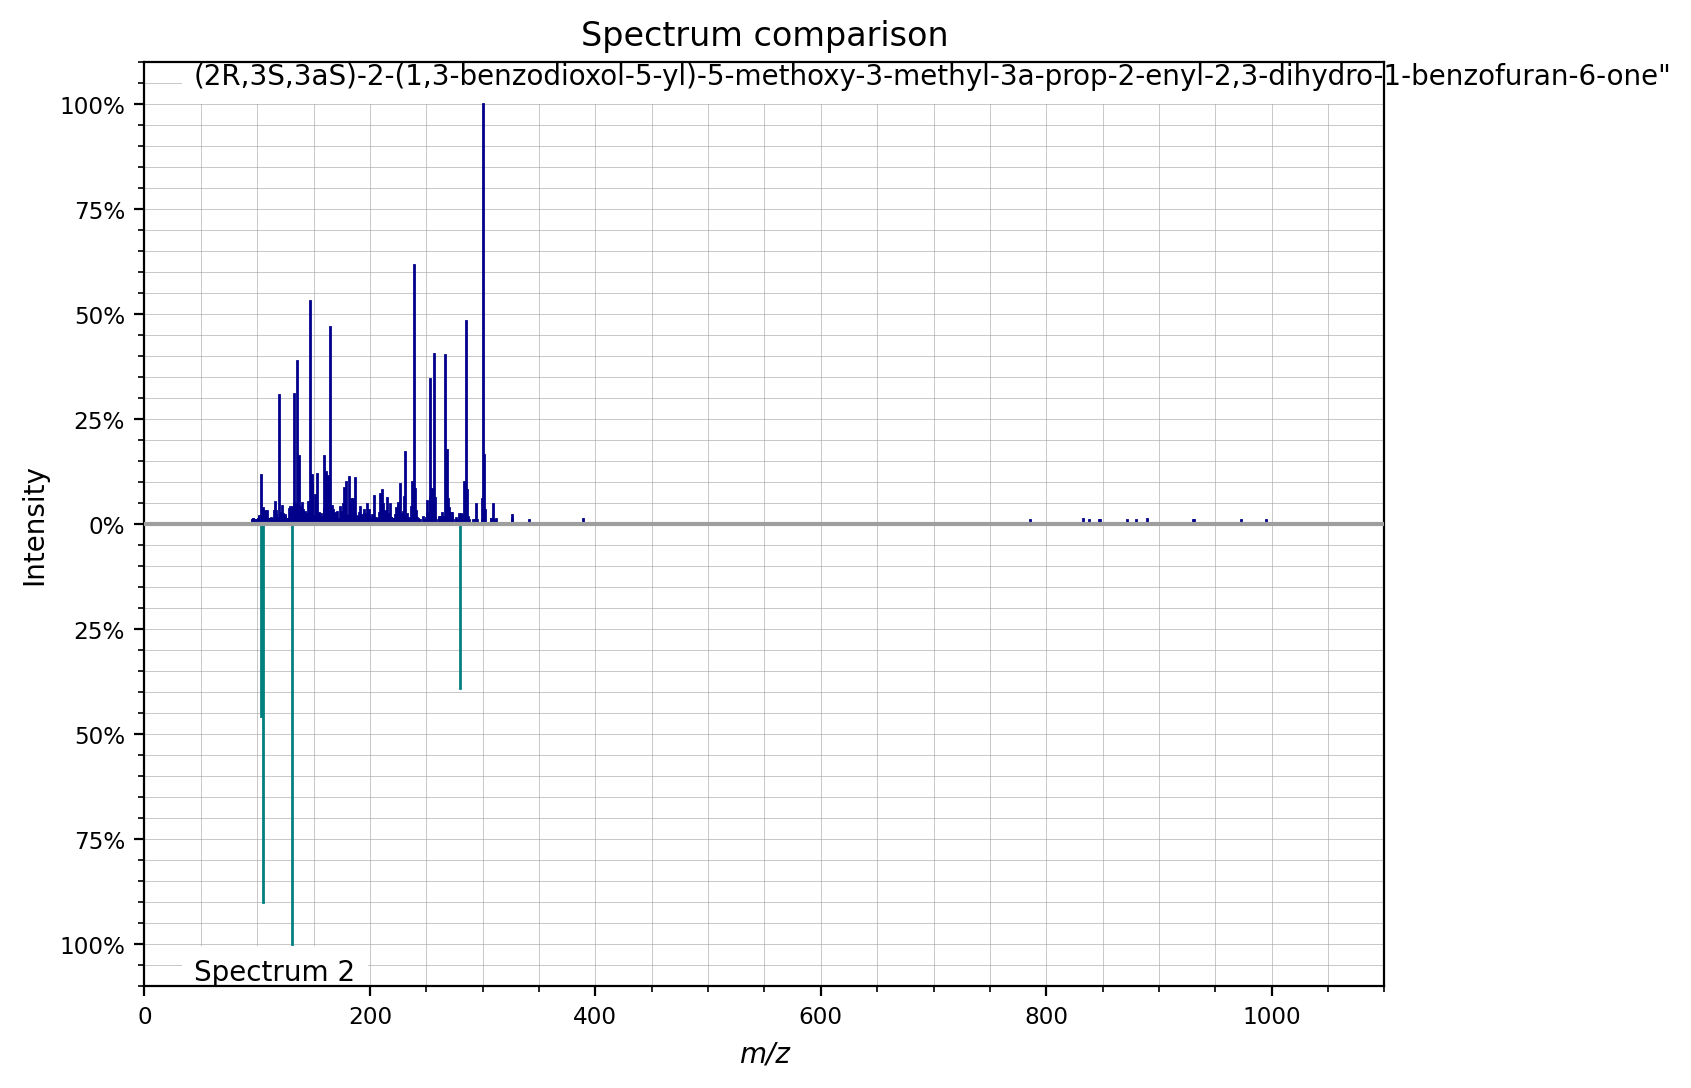

In [ ]:
cleaned_spectra[10].plot_against(optimized_motif_spectra[12])


We use rdkit fingerprint for the motifs and for indole and then we check if indole is part of the motif or not. If indole is part of the substructure the score should be 1.

In [ ]:
suspect_smiles = "C=CCN1C(=O)NC(=O)/C(=C/c2c(CCN(C)C(=O)c3ccccc3)cc3c(c2OC)OCO3)C1=O"
suspect_mol = MolFromSmiles(suspect_smiles)
suspect_fp = MACCSkeys.GenMACCSKeys(suspect_mol)

In [ ]:
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import ExplicitBitVect

In [ ]:
colors = []
similarities = []  

for index, fp in enumerate(motif_fps):
    fp_vec = ExplicitBitVect(len(fp))
    for i, bit in enumerate(fp):
        if bit:
            fp_vec.SetBit(i)
    similarity = DataStructs.TanimotoSimilarity(fp_vec, suspect_fp)
        
    # Append the similarity value to the list
    similarities.append(similarity)

    if similarity >= 0.85:
        colors.append('red')
        print(f'Index of similarity >= 0.70: {index}',similarity)  # Print the index
    else:
        colors.append('blue')


In [ ]:
%matplotlib qt%matplotlib qt

UsageError: unrecognized arguments: qt


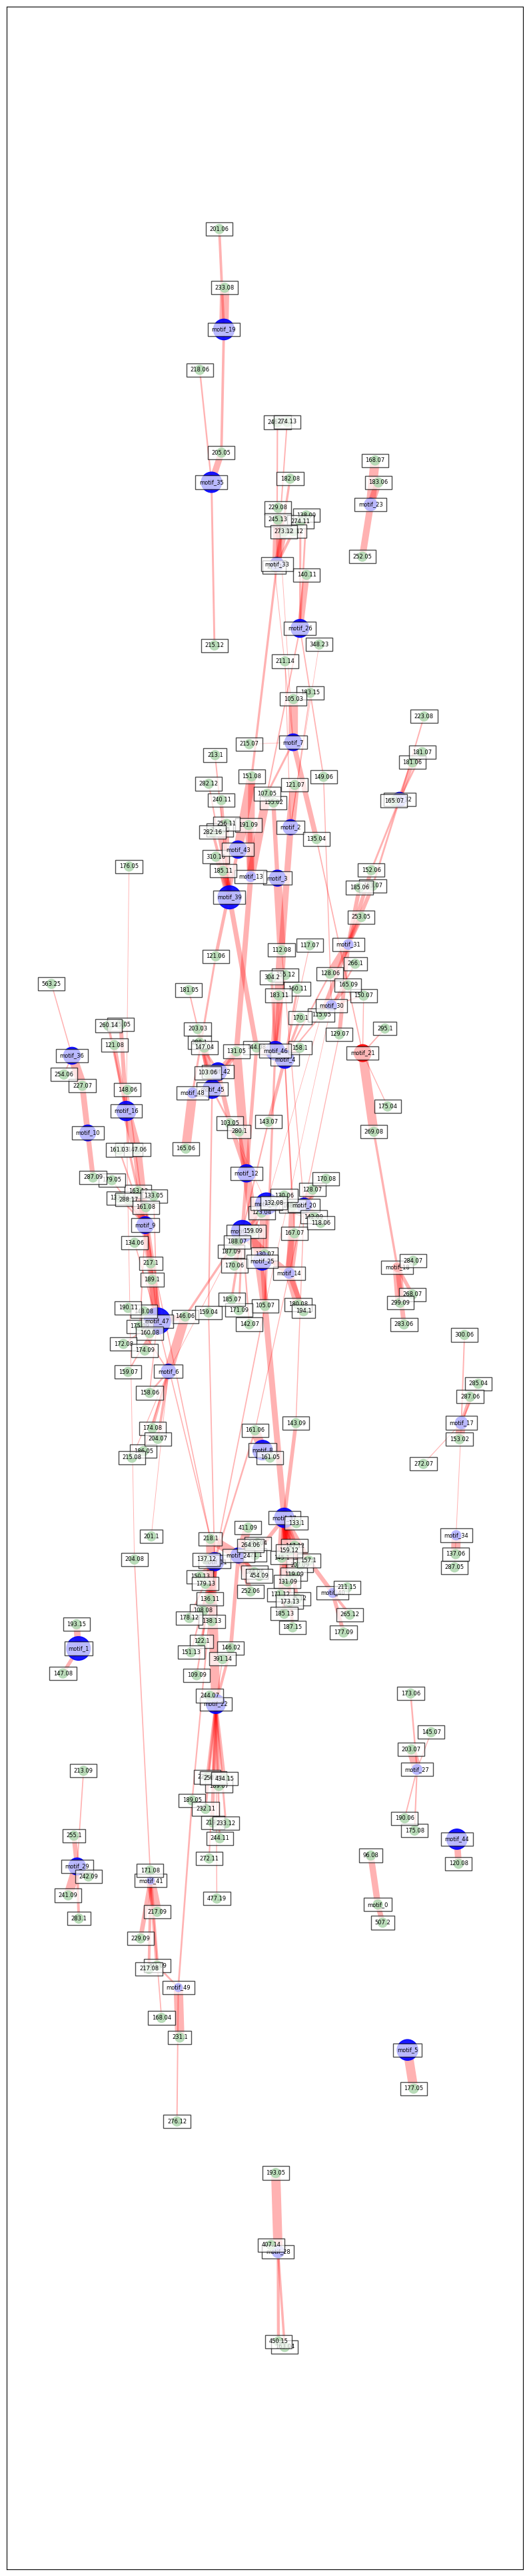

In [ ]:
create_interactive_motif_network(optimized_motif_spectra, 2, clusters_similarity, smiles_clusters, optimized_clusters, colors)

(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>)

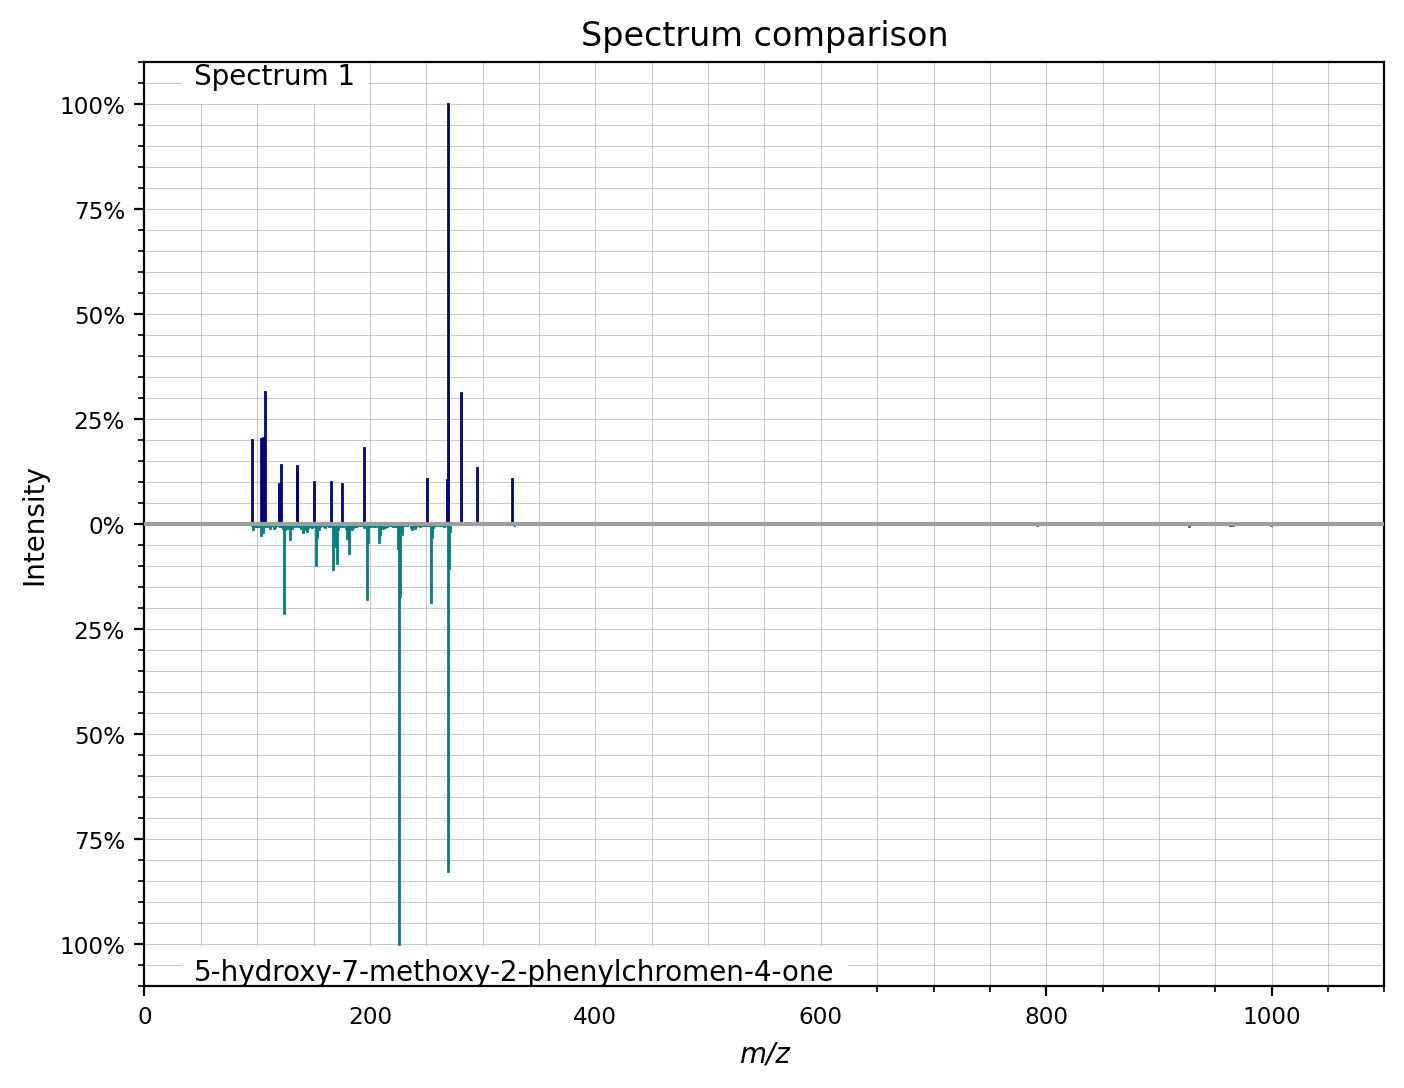

In [ ]:
motif_spectra[21].plot_against(cleaned_spectra[2])


In [ ]:
smiles_gnps

['OC(=O)[C@H](NC(=O)CCN1C(=O)[C@@H]2Cc3ccccc3CN2C1=O)c4ccccc4',
 'O=C(N1[C@@H](C#N)C2OC2c3ccccc13)c4ccccc4',
 'COc1cc(O)c2c(=O)cc(oc2c1)c3ccccc3',
 'COc1c2OCOc2cc(CCN(C)C(=O)c3ccccc3)c1/C=C\\4/C(=O)NC(=O)N(CC=C)C4=O',
 'CC(C)[C@H](NC(=O)N1[C@@H](C(C)C)C(=O)Nc2ccccc12)C(=O)N[C@@H](Cc3ccccc3)C(=O)O',
 'OC(COC(=O)c1ccccc1)C(O)C(O)COC(=O)c2ccccc2',
 'Cc1c(Cc2ccccc2)c(=O)oc3c(C)c(OCC(=O)N[C@@H](Cc4ccccc4)C(=O)O)ccc13',
 'CC(Cc1c[nH]c2ccccc12)C(=O)O',
 'COc1ccc(CNC(=O)[C@@H](NC(=O)C2CCN(CC2)C(=O)[C@@H](N)CC(C)C)C(C)C)cc1',
 'Cc1c(Br)c(=O)oc2cc(OCC(=O)N3C[C@H]4C[C@@H](C3)c5cccc(=O)n5C4)ccc12',
 'COC1=C[C@]2(CC=C)[C@H](C)[C@@H](OC2=CC1=O)c3ccc4OCOc4c3',
 'CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CC(=O)O)C(=O)O',
 'C/C=C(\\C)/C(=O)N[C@H]([C@@H](O)C(=O)O[C@H]\\1C[C@@]2(O)[C@@H](OC(=O)c3ccccc3)C4[C@@]5(CO[C@@H]5C[C@H](O)[C@@]4(C)C(=O)[C@H](OC(=O)C)/C(=C1\\C)/C2(C)C)OC(=O)C)c6ccccc6',
 'COc1cc2[nH]c3ccccc3c2cc1C',
 'O=C(Oc1cccc2ccccc12)c3ccccc3',
 'COc1ccc2[nH]c3c(CCN4C(=O)N([C

In [ ]:
from rdkit import Chem

# List of SMILES strings
smiles_list = smiles_gnps

# Store unique connected substructures along with their original indices
substructure_map = {}

for index, smiles in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smiles)
    
    if mol:  # Check if the molecule was created successfully
        # Get all connected components in the molecule
        for component in Chem.GetMolFrags(mol, asMols=True):
            # Convert each connected component to SMILES
            substructure_smiles = Chem.MolToSmiles(component)
            # Add to the map with the index
            if substructure_smiles not in substructure_map:
                substructure_map[substructure_smiles] = []
            substructure_map[substructure_smiles].append(index)

# Print the unique connected substructures along with their original indices

#for sub, indices in substructure_map.items():
 #   print(f"{sub}: Found in original indices {indices}")







{'O=C(CCN1C(=O)[C@@H]2Cc3ccccc3CN2C1=O)N[C@@H](C(=O)O)c1ccccc1': [0], 'N#C[C@H]1C2OC2c2ccccc2N1C(=O)c1ccccc1': [1], 'COc1cc(O)c2c(=O)cc(-c3ccccc3)oc2c1': [2], 'C=CCN1C(=O)NC(=O)/C(=C/c2c(CCN(C)C(=O)c3ccccc3)cc3c(c2OC)OCO3)C1=O': [3], 'CC(C)[C@H](NC(=O)N1c2ccccc2NC(=O)[C@@H]1C(C)C)C(=O)N[C@@H](Cc1ccccc1)C(=O)O': [4], 'O=C(OCC(O)C(O)C(O)COC(=O)c1ccccc1)c1ccccc1': [5], 'Cc1c(Cc2ccccc2)c(=O)oc2c(C)c(OCC(=O)N[C@@H](Cc3ccccc3)C(=O)O)ccc12': [6], 'CC(Cc1c[nH]c2ccccc12)C(=O)O': [7], 'COc1ccc(CNC(=O)[C@@H](NC(=O)C2CCN(C(=O)[C@@H](N)CC(C)C)CC2)C(C)C)cc1': [8], 'Cc1c(Br)c(=O)oc2cc(OCC(=O)N3C[C@H]4C[C@@H](C3)c3cccc(=O)n3C4)ccc12': [9], 'C=CC[C@]12C=C(OC)C(=O)C=C1O[C@@H](c1ccc3c(c1)OCO3)[C@H]2C': [10], 'Cc1ccc(S(=O)(=O)N[C@H](C(=O)N2CCC(C(=O)N[C@@H](CC(=O)O)C(=O)O)CC2)C(C)C)cc1': [11], 'C/C=C(\\C)C(=O)N[C@@H](c1ccccc1)[C@@H](O)C(=O)O[C@H]1C[C@@]2(O)[C@@H](OC(=O)c3ccccc3)C3[C@](C)(C(=O)[C@H](OC(C)=O)C(=C1C)C2(C)C)[C@@H](O)C[C@H]1OC[C@@]31OC(C)=O': [12], 'COc1cc2[nH]c3ccccc3c2cc1C': [13], 'O=C(Oc1ccc

We can see that 6 motifs contain indole structures as part of the substructure. Next to our selected motif 60, motif 20 and motif 49 are looking really promising. For simplicifation reasons we wil still focus on our motif 60.

> **_TIPP:_** Fingerprints can surely be used like shown here, but another great application would be to train a machine learning models to predict properties of motifs and thereby sort motifs with a desired property. The property should be highly dependent on substructures.

## Save your results in a .m2m format (similar to mgf)

If you are happy with the results from the modeling you can store the result in a folder in .m2m format. This is the format of the former MS2LDA/MotifDB program. This format looks similar to a mgf format but it contains losses and fragments. The folder name should not already exist.

In [ ]:
#non_existing_folder_name = "notebooks/NP\ with\ Indole"
#store_m2m_folder(motif_spectra, non_existing_folder_name)

## Save your results in local MotifDB

Our prefered way to store found motifs in MS2LDA is a dataframe format based on the MassQL format. Therefore you need to download the MassQueryLanguage4Motifs repository go in the repository directory and install the package via ```pip install .```. Massql should not already be installed. <br> 
The big advantage of using the MassQL format is that we can use MassQL to query the MotifDB database. The dataframes of different experiments can simply be combined with ```pd.concatenate()```.

In [ ]:
motif_DB_ms1, motif_DB_ms2 = motifs2motifDB(optimized_motif_spectra)

In [ ]:
motif_DB_ms2.head()

frag_mz  frag_intens  loss_mz  loss_intens  charge  ms2accuracy  \
0    96.08     0.679955      NaN          NaN       1        0.005   
1   507.20     0.562044      NaN          NaN       1        0.005   
2   147.08     0.389115      NaN          NaN       1        0.005   
3   193.15     0.700111      NaN          NaN       1        0.005   
4   112.08     0.670806      NaN          NaN       1        0.005   

                                    short_annotation annotation motif_id  \
0  [COc1c2c(nc3occc13)C(CC=C(C)C)(OC)C(=O)C=C2, C...       None  motif_0   
1  [COc1c2c(nc3occc13)C(CC=C(C)C)(OC)C(=O)C=C2, C...       None  motif_0   
2  [CCOP(=O)(C(=O)c1c(C)cc(C)cc1C)c1ccccc1, COc1c...       None  motif_1   
3  [CCOP(=O)(C(=O)c1c(C)cc(C)cc1C)c1ccccc1, COc1c...       None  motif_1   
4  [COc1ccc(CNC(=O)C(NC(=O)C2CCN(C(=O)C(N)CC(C)C)...       None  motif_2   

  motifset                              scan  ms1scan  
0  unknown  9b748bfabe799e4d57b34bc9124c4e53        0  
1  unknown  9b748bfabe799e4d57b34bc9124c4e53        0  
2  unknown  64a0a6695976665f77657ec28c15ec05        0  
3  unknown  64a0a6695976665f77657ec28c15ec05        0  
4  unknown  768d99bde8554e4fb313944d185c9d79        0

motif_DB_ms1 is not of our interest since motifs only have MS2 information, but without changing the entire MassQL script we still need generate it and also use it as input. Let's query our generated MotifDB for two fragments from motif 60.

In [ ]:
input_query = "QUERY scaninfo(MS2DATA) WHERE MS2MZ=117.06:TOLERANCEMZ=0.005 AND MS2MZ=118.06:TOLERANCEMZ=0.005"
results_peaks = msql_engine.process_query(input_query, "", ms1_df=motif_DB_ms1, ms2_df=motif_DB_ms2)
results_peaks

TOTAL QUERIES 1


100%|██████████| 1/1 [00:00<00:00, 150.33it/s]


Empty DataFrame
Columns: []
Index: []

In [ ]:
results_peaks
#?

Empty DataFrame
Columns: []
Index: []

We can see that only motif_60 has fragment 116.05 and fragment 118.06 at the same time.

## Search for patterns in motifDB

We already stored the existing MotifDB from the MS2LDA.org version in the MassQL dataframe format and now we can import the MotifDB with pandas and query MotifDB for the same fragments as above;

In [ ]:
motif_DB_ms1 = pd.read_feather("MS2LDA/MotifDB/MotifDB_MS1.feather")
motif_DB_ms2 = pd.read_feather("MS2LDA/MotifDB/MotifDB_MS2.feather")

In [ ]:
input_query = "QUERY scaninfo(MS2DATA) WHERE MS2MZ=117.06:TOLERANCEMZ=0.005 AND MS2MZ=118.06:TOLERANCEMZ=0.005"
results_peaks = msql_engine.process_query(input_query, "", ms1_df=motif_DB_ms1, ms2_df=motif_DB_ms2)
results_peaks

TOTAL QUERIES 1


100%|██████████| 1/1 [00:00<00:00, 49.40it/s]


motifset  motif_id            short_annotation  \
0   MIADB_pos_60  motif_13       Corynanthean_skeleton   
1   MIADB_pos_60  motif_55  indole_in_Yohimbane_series   
2  MIADB_pos_100   motif_7       Corynanthean_skeleton   
3   MIADB_pos_60  motif_39           Vobasane_skeleton   

                   annotation  ms1scan charge  \
0       Corynanthean_skeleton        0      1   
1  indole_in_Yohimbane_series        0      1   
2       Corynanthean_skeleton        0      1   
3           Vobasane_skeleton        0      1   

                               scan          i  mslevel  
0  13ed7dc0388a4bf5793ea34242de7ec6   5.008007        2  
1  51a74e83b1a6d38880ea3f13d9a3d704   8.948946        2  
2  5b2f7cf492ee9a62986d12291be30ef7   2.425962        2  
3  9dd82e34002cd4b0e57fa66a958dded9  15.655511        2

We can see that two motifsets show a match. Both annotations are Corynanthean_skeleton and according to this paper (https://www.researchgate.net/publication/341932327_Corynanthean-Epicatechin_Flavoalkaloids_from_Corynanthe_pachyceras) they would include indole substructures.

## Retrieve motif spectra from MotifDB

Since MotifDB is a dataframe, every pandas dataframe operation can be applied to optimize you own workflow. In the next step we will convert the dataframe results back to motif spectra. If you only to have motifs from one motifset or a certain charge or annotation you can build filters with the ```loc``` function for example.

In [ ]:
retrieved_motif_spectra = motifDB2motifs(motif_DB_ms2, results_peaks)

In [ ]:
retrieved_motif_spectra

[Spectrum(precursor m/z=0.00, 113 fragments between 103.0 and 686.3),
 Spectrum(precursor m/z=0.00, 121 fragments between 103.0 and 415.2),
 Spectrum(precursor m/z=0.00, 67 fragments between 101.0 and 297.2),
 Spectrum(precursor m/z=0.00, 136 fragments between 103.0 and 450.2)]

Now we have retrived the 2 matches from MotifDB. Let's check out how the motif looks like by plotting it.

Motif 1 frag mz: [103.05 105.07 106.07 107.07 115.05 116.06 117.06 117.06 117.07 118.06
 118.07 121.09 127.05 128.06 129.07 130.06 130.07 130.17 131.07 131.08
 132.08 134.1  141.07 142.07 143.07 144.08 146.06 147.08 148.11 152.06
 153.07 154.07 155.07 156.08 158.06 159.07 160.07 160.11 161.08 161.12
 162.09 165.07 166.07 167.07 168.08 169.08 172.08 173.08 174.09 174.21
 175.09 178.07 179.08 180.08 181.09 182.09 183.09 184.09 185.11 187.1
 188.11 191.07 192.08 192.1  193.09 194.1  194.11 195.1  196.1  197.1
 198.11 204.08 205.09 206.09 206.12 207.1  207.12 208.11 208.12 208.13
 209.11 210.11 212.13 216.08 217.09 218.1  219.1  220.11 220.12 220.13
 221.11 221.13 222.12 223.13 224.12 224.13 226.14 230.1  231.1  232.11
 233.11 234.12 235.12 236.14 238.14 240.16 242.14 246.13 248.14 249.14
 250.13 254.14 264.14 307.18 308.18 326.18 338.18 369.22 370.22 385.21
 415.22]
Motif 1 loss mz: [ 31.04  43.04  43.04  57.05  58.04  59.04  71.04  72.06  73.06  74.07
  75.07  76.08  77.09  84.06  85.06 

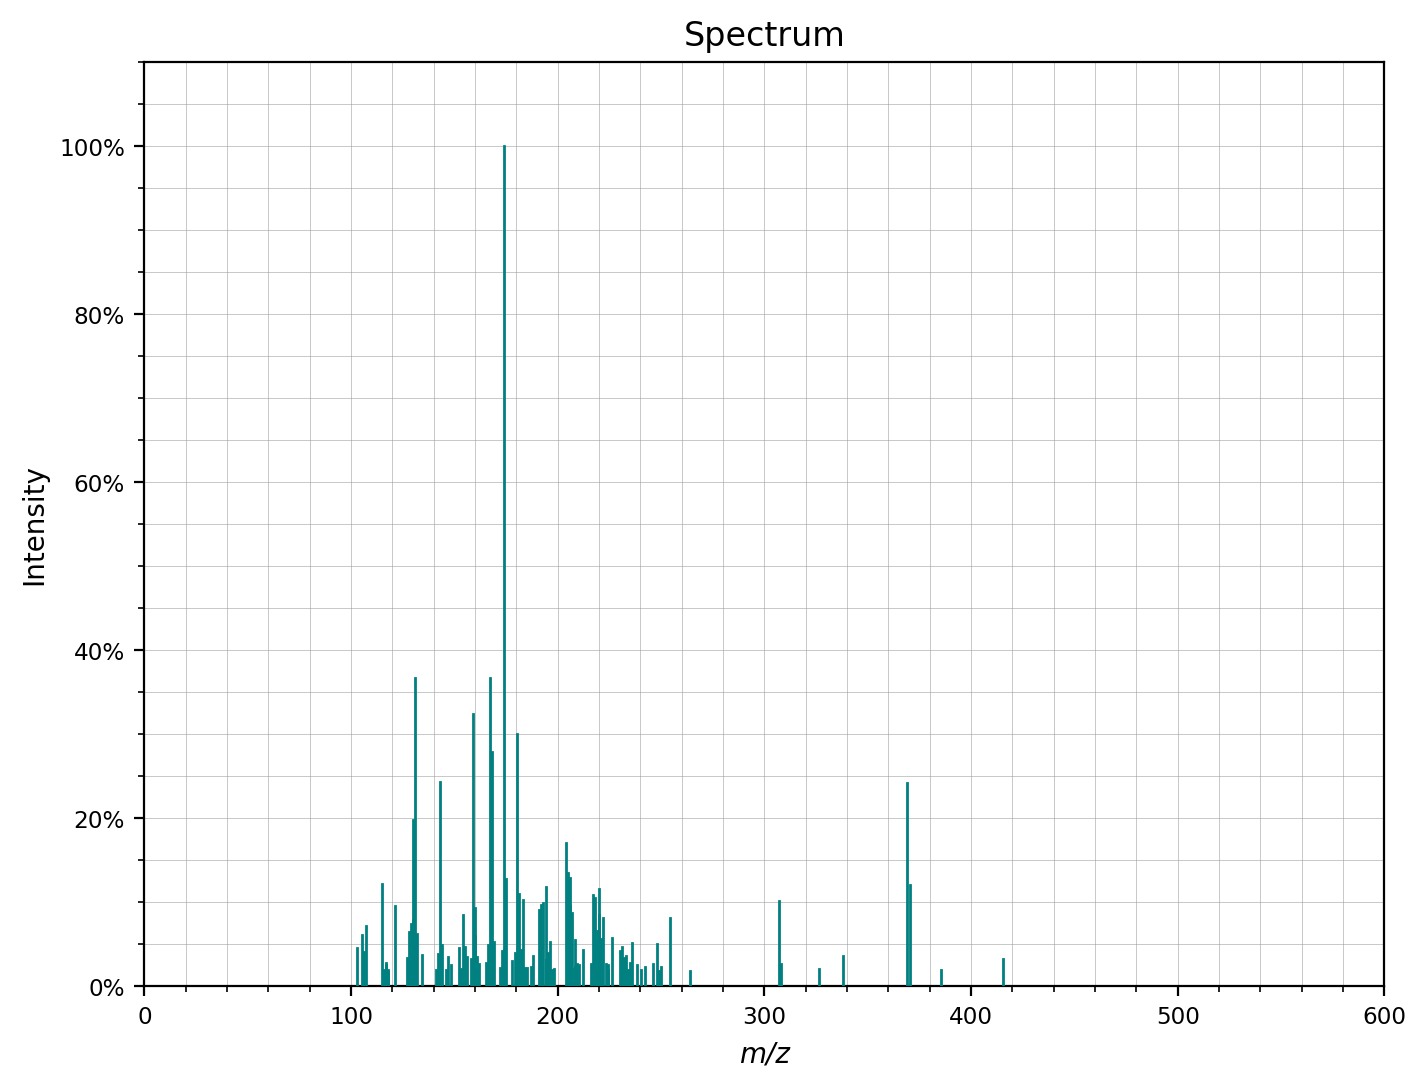

In [ ]:
retrieved_motif_spectra[1].plot()
print(f"Motif 1 frag mz: {retrieved_motif_spectra[1].peaks.mz}")
print(f"Motif 1 loss mz: {retrieved_motif_spectra[1].losses.mz}")

## Screening

Now, since we found a motif corresponding to indole and also queried and found results on MotifDB we want to use this motif to screen against a unknown database. We downloaded a GNPS library that should contain indole substructures.

In [ ]:
mgf_path_screen = "datasets/ECG-ACYL-AMIDES-C4-C24-LIBRARY.mgf"
A,B,C,D = screen_motifs(mgf_path_screen, optimized_motif_spectra, smiles_clusters, motif_selection=[55])

IndexError: list index out of range

In [ ]:
f"matches in A: {len(A)}, matches in B:, {len(B)}, matches in C:, {len(C)}, matches in D:, {len(D)}"

'matches in A: 4, matches in B:, 33, matches in C:, 0, matches in D:, 161'

A - D are different classes that represent different confidence in motif matches with A being the highest confidence. You can read more about it in the documentation. <br>
For motif 60 we see no matches at level A and 1 match at level B. Let's see the compound found in at level B.

Let's also see what matches were found in category D.

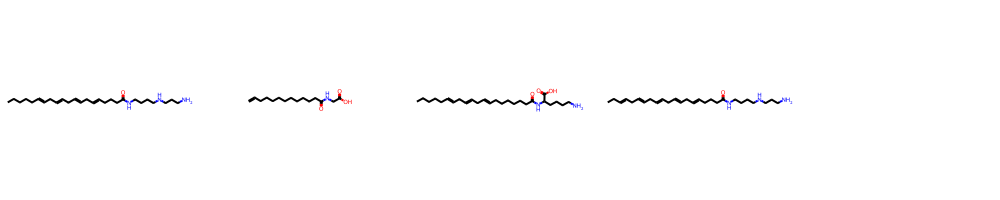

In [ ]:
MolsToGridImage([MolFromSmiles(A[k].get("smiles")) for k in range(len(A))], molsPerRow=5)

We see that even level D show nearly always good matches. Level D relies only on 1 feature and therefore should be valued to much for complex substructures, but one of the fragments seemed to be very specific for indole.

We can also use one of the MotifDB retrieved compounds for the screening.

In [ ]:
A,B,C,D = screen_motifs(mgf_path_screen, retrieved_motif_spectra, ["empty"], motif_selection=[55])

IndexError: list index out of range

In [ ]:
f"matches in A: {len(A)}, matches in B:, {len(B)}, matches in C:, {len(C)}, matches in D:, {len(D)}"

'matches in A: 114, matches in B:, 3, matches in C:, 102, matches in D:, 180'

We can already see that way more compounds were found in all levels. This is due to large number of fragments and losses in this motif. This can also lead to false positive assignments, since it has a higher chance of spectral overlap than an optimized motif.

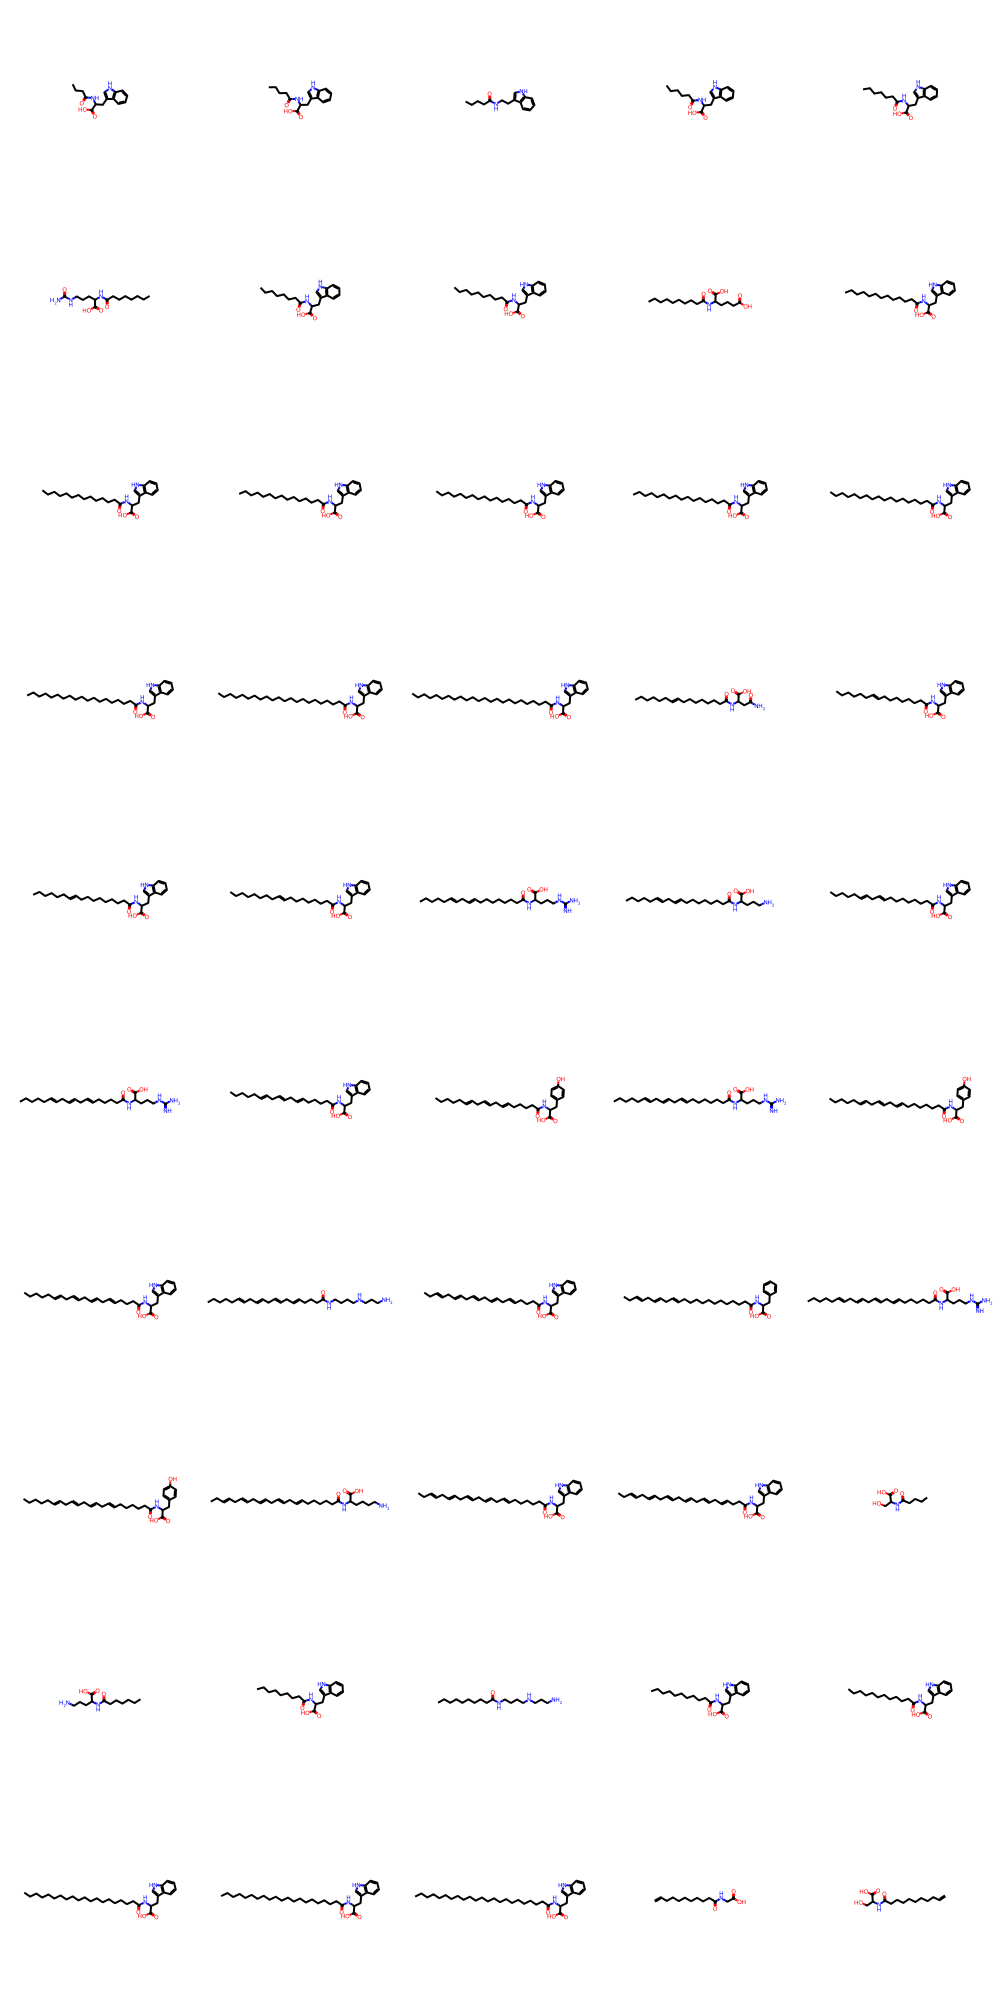

In [ ]:
MolsToGridImage([MolFromSmiles(D[k].get("smiles")) for k in range(len(A))], molsPerRow=5)

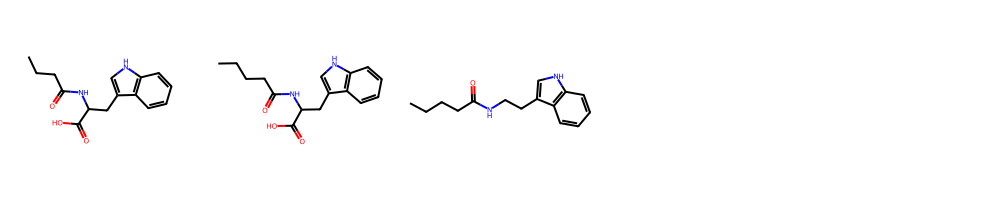

In [ ]:
MolsToGridImage([MolFromSmiles(D[k].get("smiles")) for k in range(len(B))], molsPerRow=5)

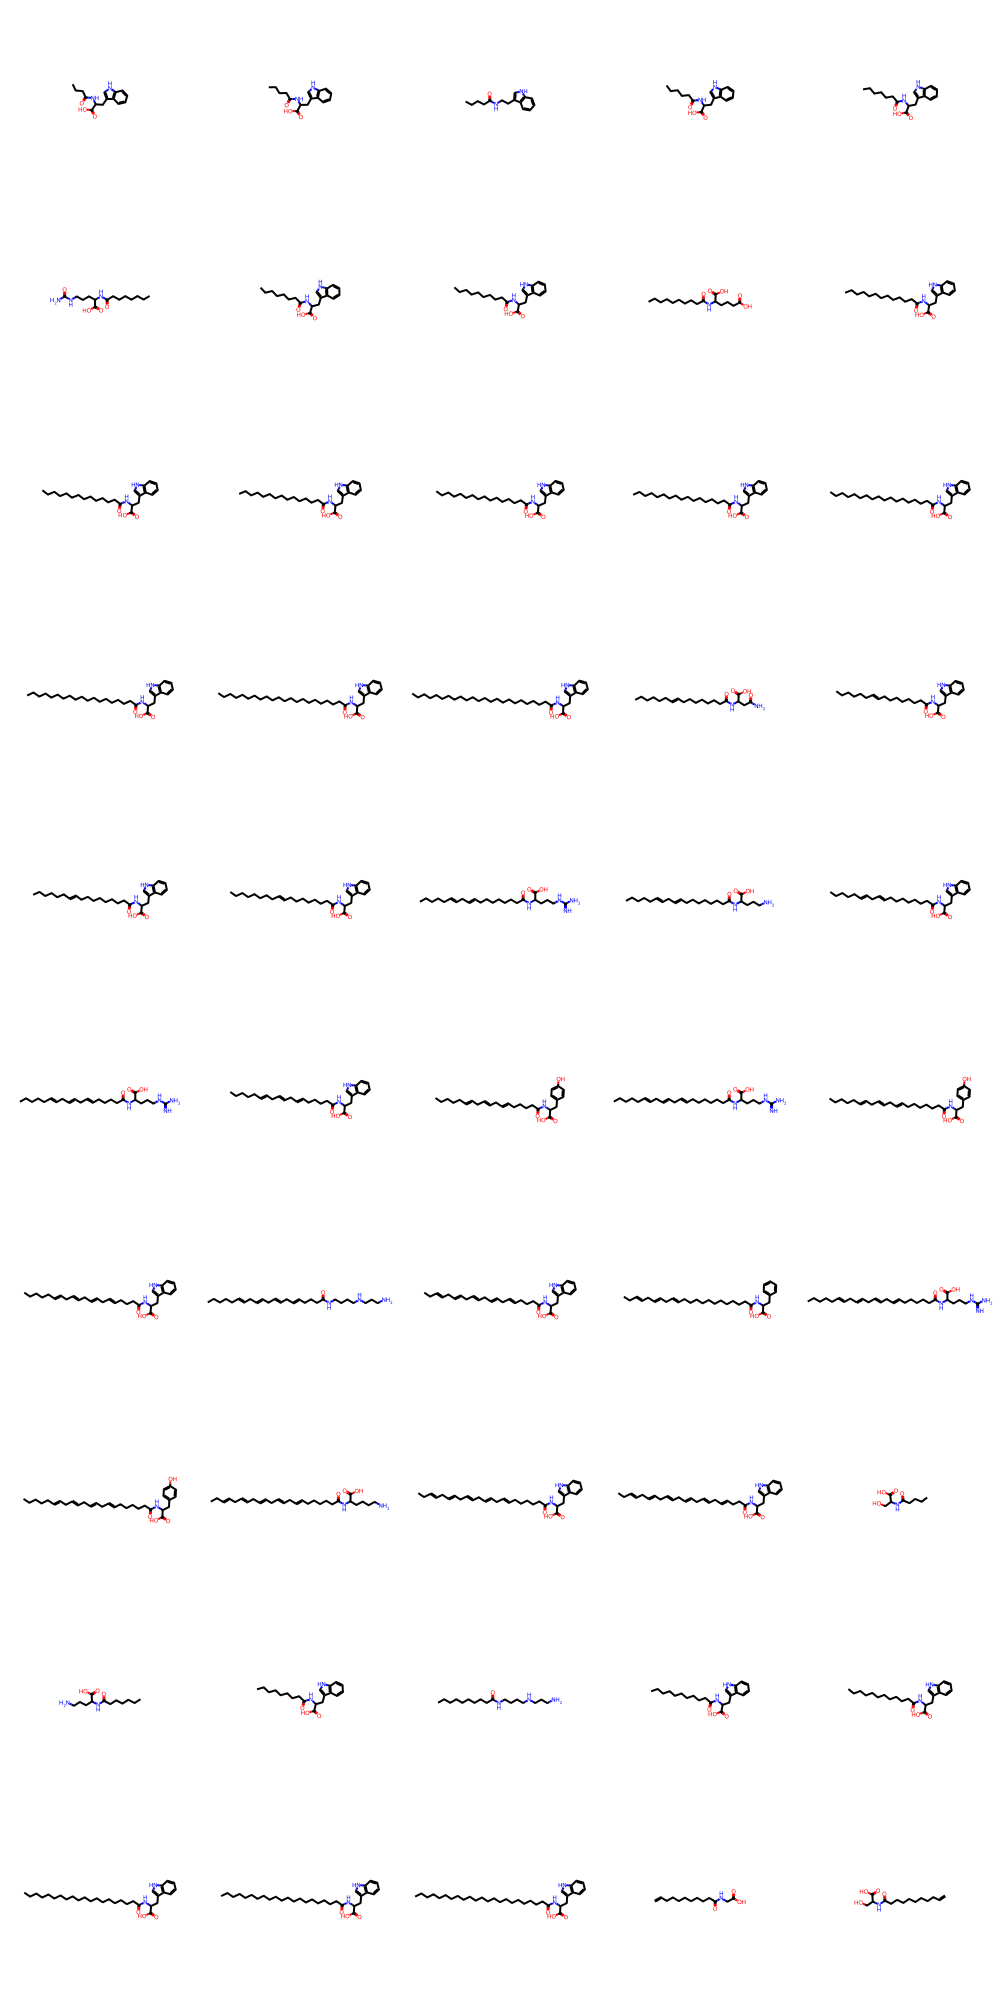

In [ ]:
MolsToGridImage([MolFromSmiles(D[k].get("smiles")) for k in range(len(C))], molsPerRow=5)

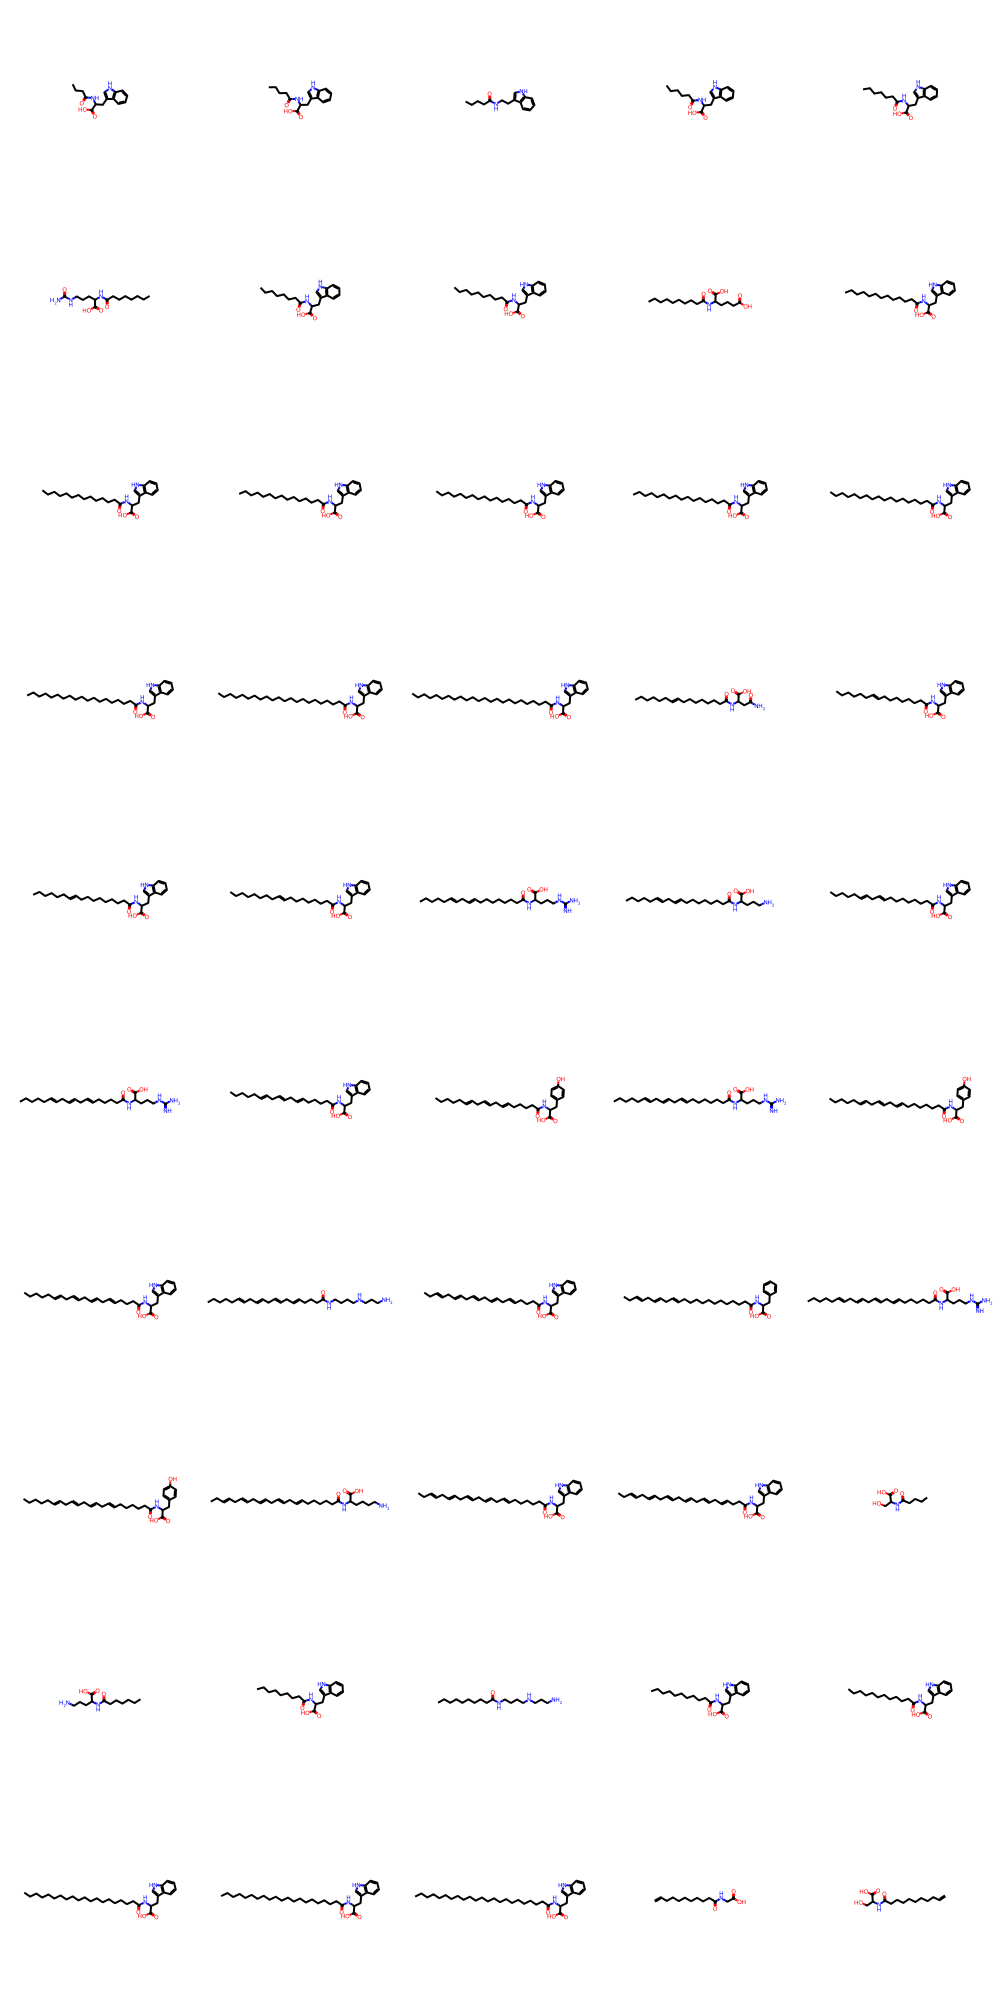

In [ ]:
MolsToGridImage([MolFromSmiles(D[k].get("smiles")) for k in range(len(D))], molsPerRow=5)

Level A, B, C, and D all look very similar in their result and all show good results. Be aware that the choosen dataset is focus on this kind of structures and therefore is it less overlap expected than in for example food samples.

> **_TIPP:_**  If you want to evaluate the goodness of a motif by looking at the false positive matches, do never use the same dataset for modeling and screening, since the model learnt the specifics of the dataset and it needs a new dataset to check if the generatlization for a substructures was successful. Similar to all machine learning methods.